In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from transformers import RobertaTokenizer, RobertaConfig, TFRobertaModel, AutoTokenizer, CLIPTextModelWithProjection
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.spatial import distance
import torch
import torch.nn.functional as F

BERT_MODEL = "roberta-base"  # Specify the RoBERTa model
MAX_LENGTH = 128
CLIP_MAX_LENGTH = 77  # Set this to the maximum sequence length supported by CLIP
TEST_SIZE = 0.2
SEED = 42

USE_ATT = True

BERT_DROPOUT = 0.2
LSTM_UNITS = 512
DENSE_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_DROPOUT = 0.2
EPOCHS = 10  # (Default 10)
BATCH_SIZE = 32

def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

random_seed(SEED)

# Load the CLIP model and tokenizer
clipmodel = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").cuda()
cliptokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")

def attention_weighted_average(chunk_embeds):
    # Convert to tensor
    chunk_embeds = torch.tensor(chunk_embeds, dtype=torch.float32)
    
    # Linear transformation to get attention scores
    att_weights = torch.nn.Linear(chunk_embeds.size(-1), 1, bias=False)(chunk_embeds)
    att_weights = F.softmax(att_weights, dim=0)
    
    # Compute the weighted average of chunk embeddings
    weighted_avg = torch.sum(att_weights * chunk_embeds, dim=0)
    
    return weighted_avg.detach().numpy()  # Detach from the graph before converting to numpy


def get_clip_embeddings(sentences, cliptokenizer, clipmodel, max_length):
    clip_embeds = []
    for sentence in tqdm(sentences):
        words = sentence.split()
        if len(words) > max_length:
            chunks = [words[i:i + max_length] for i in range(0, len(words), max_length)]
            chunk_embeds = []
            for chunk in chunks:
                chunk_sentence = " ".join(chunk)
                clipinputs = cliptokenizer(chunk_sentence, return_tensors="pt", padding="max_length", max_length=max_length, truncation=True)
                clipinputs["input_ids"] = clipinputs["input_ids"].cuda()
                clipinputs["attention_mask"] = clipinputs["attention_mask"].cuda()
                outputs = clipmodel(**clipinputs)
                chunk_embeds.append(outputs.text_embeds.cpu().detach().numpy())
            # Compute weighted average using attention mechanism
            weighted_avg_embed = attention_weighted_average(chunk_embeds)
            clip_embeds.append(weighted_avg_embed)
        else:
            clipinputs = cliptokenizer(sentence, return_tensors="pt", padding="max_length", max_length=max_length, truncation=True)
            clipinputs["input_ids"] = clipinputs["input_ids"].cuda()
            clipinputs["attention_mask"] = clipinputs["attention_mask"].cuda()
            outputs = clipmodel(**clipinputs)
            clip_embeds.append(outputs.text_embeds.cpu().detach().numpy())
    return np.vstack(clip_embeds)


def tokenize(sentences, tokenizer):
    input_ids, input_masks = [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence,
                                       add_special_tokens=True,
                                       max_length=MAX_LENGTH,
                                       padding='max_length',
                                       truncation=True,
                                       return_attention_mask=True,
                                       return_token_type_ids=False)  # Roberta doesn't use token_type_ids
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])

    return (np.asarray(input_ids, dtype='int32'),
            np.asarray(input_masks, dtype='int32'))

# Define base Roberta configs
config = RobertaConfig.from_pretrained(BERT_MODEL,
                                       output_hidden_states=False,
                                       attention_probs_dropout_prob=BERT_DROPOUT,
                                       output_attentions=True)
config.output_hidden_states = False
transformer_model = TFRobertaModel.from_pretrained(BERT_MODEL, config=config)

# Freeze the pre-trained layers for fine-tuning
for layer in transformer_model.layers[:3]:
    layer.trainable = False

# Defining tokenizer
tokenizer = RobertaTokenizer.from_pretrained(BERT_MODEL,
                                             add_special_tokens=True,
                                             max_length=MAX_LENGTH,
                                             padding='max_length',
                                             truncation=True)


# Load training data
train_data = pd.read_csv("../dataset/i_train.csv")
train_sentences = train_data['sentence'].tolist()
train_intensity = train_data['intensity'].tolist() 

# Load testing data
test_data = pd.read_csv("../dataset/i_test.csv")
test_sentences = test_data['sentence'].tolist()
test_intensity = test_data['intensity'].tolist() 

# Shuffle training data
train_data = list(zip(train_sentences, train_intensity))
random.shuffle(train_data)
train_sentences, train_intensity = zip(*train_data)

# Tokenize the data
train_input_ids, train_input_masks = tokenize(train_sentences, tokenizer)
test_input_ids, test_input_masks = tokenize(test_sentences, tokenizer)

# Convert intensity values to numpy arrays
y_tr = np.asarray(train_intensity)
y_te = np.asarray(test_intensity)

# Get CLIP embeddings for train and test sets
train_clip_embeds = get_clip_embeddings(train_sentences, cliptokenizer, clipmodel, CLIP_MAX_LENGTH)
test_clip_embeds = get_clip_embeddings(test_sentences, cliptokenizer, clipmodel, CLIP_MAX_LENGTH)

C:\Users\Administrator\anaconda3\envs\research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Administrator\anaconda3\envs\research\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequen

In [2]:
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Attention, Concatenate

# Inputs
input_ids_in = Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32')
clip_input_in = Input(shape=(train_clip_embeds.shape[1],), name='clip_embed', dtype='float32')

# Transformer Model for Embedding
embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]

# Bi-directional LSTM layer
X_lstm = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(embedding_layer)

# Convolutional layer
X_conv = Conv1D(filters=128, kernel_size=2, activation='relu')(X_lstm)  # Apply CNN on LSTM output

# Attention layer
if USE_ATT:
    X_att = Attention(use_scale=True)([X_conv, X_conv])
    # Combining original convolution outputs and attention outputs
    X_combined = Concatenate(axis=-1)([X_conv, X_att])
    X_pool = GlobalMaxPooling1D()(X_combined)
else:
    X_pool = GlobalMaxPooling1D()(X_conv)

# Linear layer for CLIP embeddings
clip_processed = Dense(DENSE_UNITS, activation='relu')(clip_input_in)

# Concatenate CLIP embeddings
X_combined = Concatenate(axis=-1)([X_pool, clip_processed])


# Dense layers
# X = Dense(DENSE_UNITS, activation='relu')(X_combined)
# X = Dropout(DENSE_DROPOUT)(X)
# X = Dense(DENSE_UNITS // 2, activation='relu')(X)  # Additional dense layer
# X = Dropout(DENSE_DROPOUT / 2)(X)  # Additional dropout layer
# X = Dense(1, activation='linear')(X)  # regression output


# Dense layers
X = Dense(DENSE_UNITS, activation='relu')(X_combined)
X = Dropout(DENSE_DROPOUT)(X)
X = Dense(1, activation='linear')(X)  # regression output

# Final model
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in, clip_input_in], outputs=X)

# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()])

# Model Summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_token[0][0]',            
 el)                            thPoolingAndCrossAt               'masked_token[0][0]']           
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

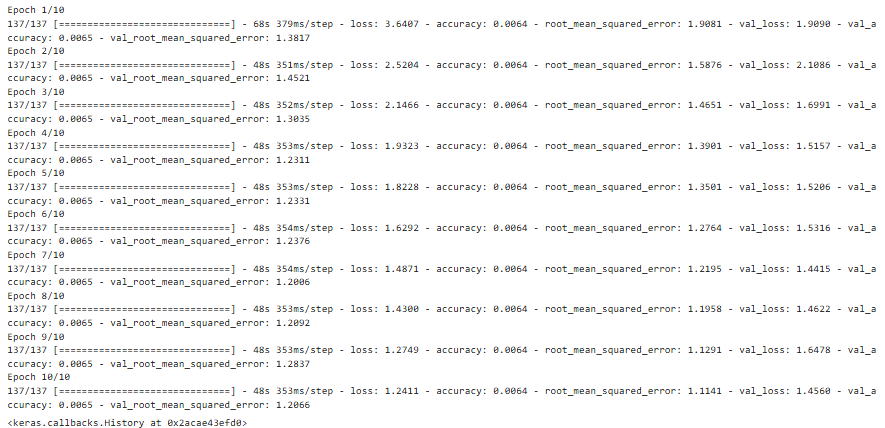

In [3]:
# Train the model
model.fit(x=[train_input_ids, train_input_masks, train_clip_embeds],
          y=y_tr,
          epochs=EPOCHS,
          validation_split=0.1,
          batch_size=BATCH_SIZE)

Epoch 1/10
137/137 [==============================] - 66s 368ms/step - loss: 3.7977 - accuracy: 0.0062 - root_mean_squared_error: 1.9488 - val_loss: 1.9832 - val_accuracy: 0.0103 - val_root_mean_squared_error: 1.4083
Epoch 2/10
137/137 [==============================] - 47s 340ms/step - loss: 2.3675 - accuracy: 0.0062 - root_mean_squared_error: 1.5387 - val_loss: 2.1114 - val_accuracy: 0.0103 - val_root_mean_squared_error: 1.4531
Epoch 3/10
137/137 [==============================] - 47s 341ms/step - loss: 2.0254 - accuracy: 0.0062 - root_mean_squared_error: 1.4232 - val_loss: 1.5660 - val_accuracy: 0.0103 - val_root_mean_squared_error: 1.2514
Epoch 4/10
137/137 [==============================] - 47s 341ms/step - loss: 1.8138 - accuracy: 0.0062 - root_mean_squared_error: 1.3468 - val_loss: 1.5613 - val_accuracy: 0.0103 - val_root_mean_squared_error: 1.2495
Epoch 5/10
137/137 [==============================] - 47s 341ms/step - loss: 1.5545 - accuracy: 0.0062 - root_mean_squared_error: 1.

In [4]:
print("TEST split", TEST_SIZE)
results = model.evaluate(x=[test_input_ids, test_input_masks, test_clip_embeds], y=y_te)
print(results)
result = model.predict(x=[test_input_ids, test_input_masks, test_clip_embeds])

TEST split 0.2
38/38 [==============================] - 10s 249ms/step - loss: 1.4961 - accuracy: 0.0058 - root_mean_squared_error: 1.2232
[1.4960979223251343, 0.005780346691608429, 1.2231508493423462]
38/38 [==============================] - 13s 246ms/step


In [5]:
result = np.array(result, dtype=np.float64)
result = result.flatten()
print("pear", stats.pearsonr(result, y_te))
print("cosine", 1 - distance.cosine(result, y_te))

pear PearsonRResult(statistic=0.8152169987287294, pvalue=4.663162635528786e-289)
cosine 0.9790006616122795


In [6]:
predictions_df = pd.DataFrame(result, columns=['roberta_clip_intensity'])

# Add the predictions to your test_data DataFrame
test_data['roberta_clip_intensity'] = predictions_df['roberta_clip_intensity']

In [7]:
test_data

,sentence,intensity,roberta_clip_intensity
0,people think illegal immigration is just about...,4,5.595707
1,and if yo bitch fast prolly cuz she out here r...,6,6.661713
2,lets hope so gas the lot including the nigger,7,6.945950
3,It is safer not to share a meal with some Musl...,4,4.435682
4,who cares about the kneeling foul african amer...,2,2.113120
...,...,...,...
1206,i stand with brianna brochu because being forc...,2,2.346062
1207,@user kill yourself o,6,1.847453
1208,now you see why god told his people to kill qu...,6,3.043703
1209,i think the one she replaced was actually a co...,2,2.264920


In [8]:
# Save the updated test_data DataFrame as a CSV file
test_data.to_csv('../dataset/intensity_result/test/test_clip.csv', index=False)

In [9]:
model.save('roberta-clip.h5')

In [10]:
from tensorflow.keras.models import load_model
import pandas as pd

In [11]:
# Load the saved model
import transformers
# Define custom objects

custom_objects = {
    'TFRobertaModel': transformers.TFRobertaModel
}

clip_model = load_model('roberta-clip.h5', custom_objects=custom_objects)

### Train 

In [15]:
results = clip_model.evaluate(x=[train_input_ids, train_input_masks, train_clip_embeds], y=y_tr)
print(results)
result = clip_model.predict(x=[train_input_ids, train_input_masks, train_clip_embeds])

152/152 [==============================] - 38s 228ms/step - loss: 0.5143 - accuracy: 0.0066 - root_mean_squared_error: 0.7171
[0.5142868161201477, 0.006607474759221077, 0.7171379327774048]
152/152 [==============================] - 37s 227ms/step


In [21]:
predictions_df = pd.DataFrame(result, columns=['roberta_clip_intensity'])

train_data = pd.read_csv("../dataset/i_train.csv")
train_sentences = train_data['sentence'].tolist()
train_intensity = train_data['intensity'].tolist() 

# Add the predictions to your test_data DataFrame
train_data['roberta_clip_intensity'] = predictions_df['roberta_clip_intensity']

In [23]:
train_data.to_csv('../dataset/intensity_result/train/train_clip.csv', index=False)